In [227]:
%%time
import xarray as xr                                                            
import numpy as np                                                         
from datetime import datetime                                                                     
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from scipy import stats
import warnings; warnings.filterwarnings('ignore') # suppress warnings
import cftime
from IPython.display import display as dp # for displaying multiple output in one cell
# Wall time: 72.2 µs

CPU times: user 50 µs, sys: 0 ns, total: 50 µs
Wall time: 59.4 µs


In [230]:
%%time
archive = '/g/data/e14/mv7494/access-om2/archive/'
exp = ['1deg_jra55_rdf_branch2000_Control_PI_Offset/', '1deg_jra55_iaf_branch2000_PI_Offset/']

rho_0 = 1035.0                       # [kg m^{-3}]
C_p = 3992.10322329649               # [J kg^{-1} K^{-1}]
area_t = xr.open_mfdataset(archive+exp[0]+'output200/ocean/ocean_grid.nc',decode_times=False).area_t

for s in range(2):
    # loading Qnet variables
    net_sfc_heating = xr.open_mfdataset(archive+exp[s]+'output*/ocean/ocean_month.nc',decode_times=False).net_sfc_heating
    frazil_3d_int_z = xr.open_mfdataset(archive+exp[s]+'output*/ocean/ocean_month.nc',decode_times=False).frazil_3d_int_z
    average_DT      = xr.open_mfdataset(archive+exp[s]+'output*/ocean/ocean_month.nc',decode_times=False).average_DT       
    # loading OHC variables
    dzt             = xr.open_mfdataset(base+exp[s]+'output*/ocean/ocean.nc',decode_times=False).dzt[0,:,:,:]    
    temp            = xr.open_mfdataset(archive+exp[s]+'output*/ocean/ocean_month.nc',decode_times=False).temp-273.15
    
    # calculating globally integrated net surface heat flux and ocean heat content
    # select only first 100 values for testing
    Qnet     = (((net_sfc_heating+frazil_3d_int_z)*area_t)*average_DT*86400).cumsum(['time']).sum(['yt_ocean','xt_ocean'])[0:100]
    OHC      = (rho_0*C_p*temp*area_t*dzt).sum(['st_ocean','yt_ocean','xt_ocean'])[0:100] # units of (J m-2 year-1)
    # ---------------------------------------------------------------------------------------------------------------------------
    
    # allocate name and load into MEM
    if s == 0:
        Qnet_clim = Qnet.load(); OHC_clim = OHC.load(); print('control')
    else:
        Qnet = Qnet.load(); OHC = OHC.load(); print('full forced simulation')
# Wall time: 48.8 s

control
full forced simulation
CPU times: user 36.1 s, sys: 12 s, total: 48.1 s
Wall time: 47.4 s


CPU times: user 36.8 ms, sys: 1.89 ms, total: 38.7 ms
Wall time: 31.7 ms


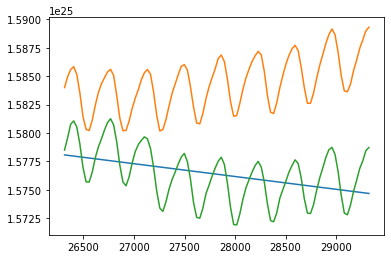

In [246]:
%%time
# calculate linear trend in control
time = Qnet_clim.time
poly_b = np.poly1d(np.polyfit(time,OHC_clim, 1))# calculating the linear trend

# remove linear trend in control from the fully forced simulation
OHC_anom = OHC - poly_b(time)
plt.plot(time,poly_b(time))
plt.plot(time,OHC)
plt.plot(time,OHC_clim)

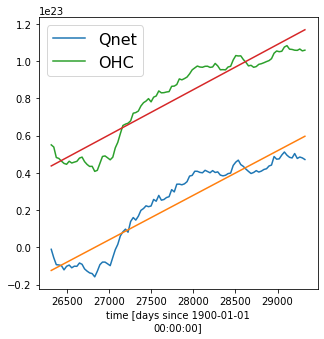

In [229]:
plt.figure(figsize=(5,5))
a.plot(label='Qnet'); 
poly_a = np.poly1d(np.polyfit(a.time,a, 1))# calculating the linear trend
plt.plot(a.time,poly_a(a.time))


b.plot(label='OHC'); 
poly_b = np.poly1d(np.polyfit(b.time,b, 1))# calculating the linear trend
plt.plot(b.time,poly_b(b.time))

plt.legend(fontsize=16)

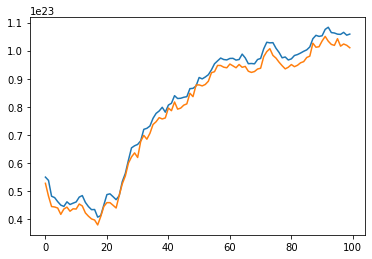

In [219]:
c = a+b[1]
plt.plot(b)
plt.plot(c)

In [214]:
# comparing the two trend values
[poly_a[1], poly_b[1], str(100-(poly_a[1]/poly_b[1])*100)+str(' %')]
#            Qnet               OHC            Difference in percentage
#             ↓                  ↓                    ↓

[2.3914951128735818e+19, 2.4274589404591895e+19, '1.4815421585999928 %']

In [21]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #